# Credit Card Routing for Online Purchase via Predictive Modelling

## 1. Business Understanding

#### Case Description:

This is your first day as a data scientist at one of the world’s largest retail companies. Already on your first day, you are invited to a meeting with important business stakeholders from the online payment department, who ask for your help: Over the past year they have encountered a high failure rate of online credit card payments. The company loses a lot of money due to failed transactions and customers become increasingly unsatisfied with the online shop.

Such online credit card payments are performed via so-called payment service providers, referred to as “PSPs” by the business stakeholders. Your company has contracts with four different PSPs and pays transaction fees for every single payment. The current routing logic is manual and rule-based. Business decision-makers, however, hope that with predictive modelling and with your help, a smarter way of routing a PSP to a transaction is possible.

#### Project Aim:

Help the business to automate the credit card routing via a predictive model. Such a model should increase the payment success rate by finding the best possible PSP for each transaction and at the same time keep the transaction fees low.

#### Task Description:

The task consists of both coding and conceptual steps. Here is a list of tasks, which should be included in your final document:

* Structure the project via the CRISP-DM or Team DS methodologies and give a recommendation of how a git repository for the project could look like. Note that you do not have to structure your final code according to your git-repository proposal.
* Assess the quality of the provided data set. Prepare and visualize your findings of the initial data analysis in order that business stakeholders can understand them in a clear and easy way.
* Provide a baseline model as well as an accurate predictive model, which fulfills business requirements, i.e. increase credit card success rate and keep fees low.
* In order that the business places confidence in your model, discuss the importance of the individual features and make the results of the model interpretable. Moreover, a sophisticated error analysis is very important for the business to understand the drawbacks of your approach.
* In the last step of the project, give a proposal of how your model could be used by the business in everyday work, for instance, via a graphical user interface (GUI).

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots
import copy
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', None)

## 2. Data Understanding:

In [2]:
# Read the Excel file into a data frame

df = pd.read_excel("PSP_Jan_Feb_2019.xlsx" ,index_col=0)

In [3]:
df.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [4]:
# Check the shape, columns, and data types of the data frame

print(df.shape)

(50410, 7)


In [5]:
column = df.columns
column

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card'], dtype='object')

In [6]:
# Count the number of Nan values in each column
(df.isnull().sum()/len(df))*100

tmsp          0.0
country       0.0
amount        0.0
success       0.0
PSP           0.0
3D_secured    0.0
card          0.0
dtype: float64

In [7]:
# Get some basic statistics of the numerical columns
df.describe()

,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266
std,96.274730,0.402160,0.426027
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


In [8]:
column = ['country','success', 'PSP', '3D_secured', 'card']

for col in column:
    unique_values = df[col].unique()
    print(f"Unique values in column {col}: {unique_values}")

Unique values in column country: ['Germany' 'Austria' 'Switzerland']
Unique values in column success: [0 1]
Unique values in column PSP: ['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']
Unique values in column 3D_secured: [0 1]
Unique values in column card: ['Visa' 'Diners' 'Master']


## 3. Data Preparation

In [9]:
duplicate = df[df.duplicated()]
print(f'number of duplicates: {len(duplicate)}')

number of duplicates: 81


In [10]:
duplicate.head(10)

,tmsp,country,amount,success,PSP,3D_secured,card
84,2019-01-01 01:28:02,Germany,37,0,UK_Card,0,Master
496,2019-01-01 09:35:38,Germany,170,0,UK_Card,0,Diners
500,2019-01-01 09:44:27,Germany,113,0,UK_Card,0,Visa
603,2019-01-01 11:32:44,Germany,170,0,UK_Card,0,Visa
1393,2019-01-02 03:06:14,Austria,229,0,UK_Card,0,Master
1444,2019-01-02 04:00:37,Germany,203,0,UK_Card,0,Master
1863,2019-01-02 12:53:12,Germany,216,0,Simplecard,0,Master
3938,2019-01-04 09:08:04,Austria,109,0,UK_Card,0,Master
4052,2019-01-04 11:57:35,Germany,77,0,UK_Card,0,Master
4783,2019-01-05 06:01:47,Germany,291,0,UK_Card,0,Master


In [11]:
initial_record_count = df.shape[0]
initial_record_count

50410

In [12]:
# Removing the duplicate records from the dataset
df.drop_duplicates(inplace=True)
final_record_count = df.shape[0]
print("Record count after removing duplicates:", final_record_count)

Record count after removing duplicates: 50329


In [13]:
#Loading the PSP transaction fees data as a dataFrame
data = {
    "PSP": ["Moneycard", "Goldcard", "UK_Card", "Simplecard"],
    "success_txnFee": [5, 10, 3, 1],
    "failure_txnFee": [2, 5, 1, 0.5]
}

# Create DataFrame
df1 = pd.DataFrame(data)
df1

,PSP,success_txnFee,failure_txnFee
0,Moneycard,5,2.0
1,Goldcard,10,5.0
2,UK_Card,3,1.0
3,Simplecard,1,0.5


In [14]:
#Merging both the dataframes into a single dataframe based on the PSP to map the transaction fee
df2 = df.merge(df1, on="PSP")

In [15]:
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0
4,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,3,1.0


In [16]:
# Sorting the dataframe by the timestamp in ascending order
df2 = df2.sort_values("tmsp")

# Finding the difference between consecutive timestamps in seconds
df2["tmsp_diff"] = (df2["tmsp"] - df2["tmsp"].shift(1)).dt.total_seconds()

# Assigning a value of 1 if the transaction is done within a minute after the previous transaction, or 0 otherwise
df2["withinMinute"] = df2["tmsp_diff"].apply(lambda x: 1 if x <= 60 else 0)

# Introducing a feature ‘noOfAttempts’ which captures the number of transaction attempts based on the given criteria
df2["noOfAttempts"] = 1

# Resetting the index
df2.reset_index(drop=True, inplace=True)

# Incrementing the 'noOfAttempts' consequently if withinMinute = 1
for i in range(df2.shape[0]-1):
    if (df2["country"][i] == df2["country"][i+1]) and (df2["amount"][i] == df2["amount"][i+1]) and (df2["withinMinute"][i+1] == 1):
        df2.at[i+1, "noOfAttempts"] = df2.at[i, "noOfAttempts"] + 1


In [17]:
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,tmsp_diff,withinMinute,noOfAttempts
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1


In [18]:
# Extract Month, Day, Hour from 'tmsp' column
df2[['Month', 'Day', 'Hour']] = df2['tmsp'].apply(lambda x: pd.Series([x.month, x.day, x.hour]))

# Map numeric day of week to weekday name
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df2['Weekday'] = df2['tmsp'].dt.dayofweek.map(weekday_map)

# Display the first few rows of the dataframe
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,tmsp_diff,withinMinute,noOfAttempts,Month,Day,Hour,Weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1,1,1,0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2,1,1,0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1,1,1,0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2,1,1,0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1,1,1,0,Tuesday


In [19]:
# Remove NaN values in 'tmsp_diff' column and drop unnecessary columns
df2["tmsp_diff"].fillna(0, inplace=True)
df2.drop(['tmsp_diff', 'withinMinute'], axis=1, inplace=True)

# Make a deep copy of df2 for label encoding
psp_df = copy.deepcopy(df2)

# Define categorical columns for label encoding
categorical_cols = ["country", "PSP", "card", "Weekday"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
for col in categorical_cols:
    psp_df[col] = label_encoder.fit_transform(psp_df[col])
    print(col, ":", label_encoder.classes_)  # Print encoded classes

# Display a sample of the transformed DataFrame
psp_df.sample(5)

country : ['Austria' 'Germany' 'Switzerland']
PSP : ['Goldcard' 'Moneycard' 'Simplecard' 'UK_Card']
card : ['Diners' 'Master' 'Visa']
Weekday : ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,Weekday
32366,2019-02-06 20:51:16,1,88,0,3,0,2,3,1.0,1,2,6,20,6
10106,2019-01-11 03:08:46,1,310,0,3,1,2,3,1.0,1,1,11,3,0
39303,2019-02-14 20:05:03,1,343,0,2,0,1,1,0.5,1,2,14,20,4
43301,2019-02-20 00:38:15,2,247,0,3,1,0,3,1.0,3,2,20,0,6
36359,2019-02-11 13:49:52,0,197,0,3,0,1,3,1.0,1,2,11,13,1


In [20]:
# Make a deep copy of df2 for one-hot encoding
df4 = copy.deepcopy(df2)

# Define categorical columns for one-hot encoding
categorical_cols = ["country", "PSP", "card", "Weekday"]

# Perform one-hot encoding
df4 = pd.get_dummies(df4, columns=categorical_cols, drop_first=True)

# Display the resulting DataFrame
print("Shape of df4:", df4.shape)
df4.head()


Shape of df4: (50329, 23)


,tmsp,amount,success,3D_secured,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,...,PSP_Simplecard,PSP_UK_Card,card_Master,card_Visa,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2019-01-01 00:01:11,89,0,0,3,1.0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
1,2019-01-01 00:01:17,89,1,0,3,1.0,2,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,2019-01-01 00:02:49,238,0,1,3,1.0,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0
3,2019-01-01 00:03:13,238,1,1,3,1.0,2,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,2019-01-01 00:04:33,124,0,0,1,0.5,1,1,1,0,...,1,0,0,0,0,0,0,0,1,0


### 3.1 Data Visualization

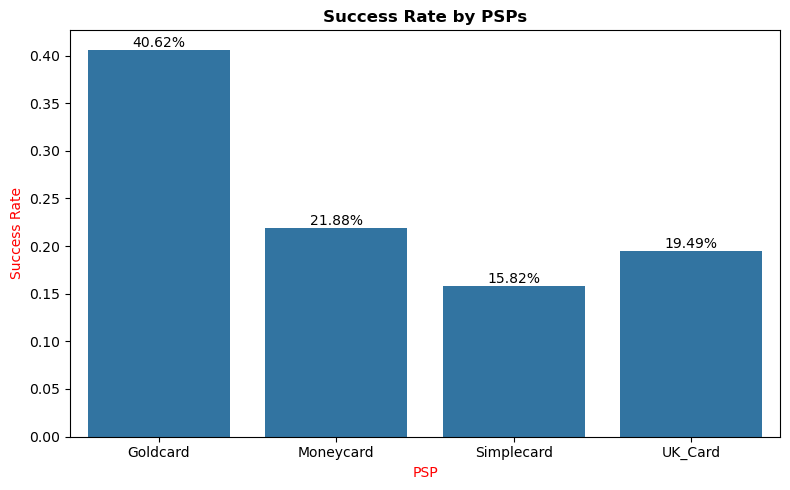

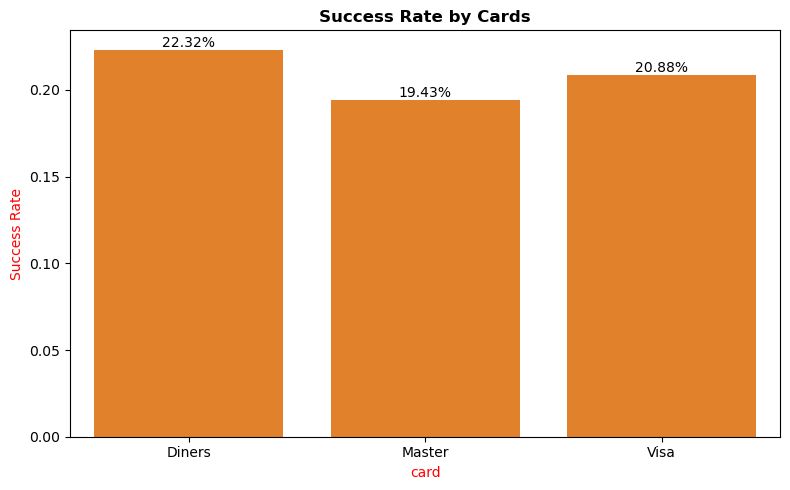

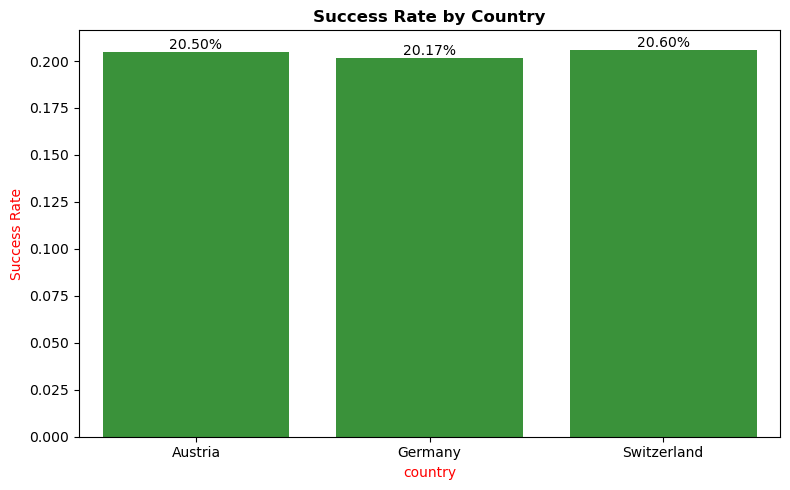

In [21]:
# Calculate average success rates
psp_success_rate_df = df2.groupby("PSP")["success"].mean().reset_index(name="psp_success_rate")
card_success_rate_df = df2.groupby("card")["success"].mean().reset_index(name="card_success_rate")
country_success_rate_df = df2.groupby("country")["success"].mean().reset_index(name="country_success_rate")

# Define different bar colors
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Display average success rates with different bar colors
for df, title, color in zip([psp_success_rate_df, card_success_rate_df, country_success_rate_df], ["Success Rate by PSPs", "Success Rate by Cards", "Success Rate by Country"], bar_colors):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=df.columns[0], y=df.columns[1], data=df, color=color)
    plt.title(title , fontweight='bold')
    plt.xlabel(df.columns[0], color = 'red')
    plt.ylabel("Success Rate" , color = 'red')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2%'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)
    plt.tight_layout()
    plt.show()

Success Rate by PSPs:
- This plot illustrates the average success rate for each Payment Service Provider (PSP). It helps in comparing the performance of different PSPs in terms of successfully processed transactions. It shows that Goldcard has the highest success rate of 40.62% and simplecard has the lowest success rate of 15.82%.

Success Rate by Cards:
- This plot shows the average success rate for each card type used in transactions. It provides insights into whether certain card types have higher success rates compared to others. It shows that Diners has the highest success rate of 22.32% and lowest success rate of 19.43%.

Success Rate by Country:
- This plot displays the average success rate for each country where transactions originate. It helps in understanding whether success rates vary significantly across different countries. It shows that switzerland has the highest success rate of 20.60% and Germany has the lowest success rate of 20.17%.

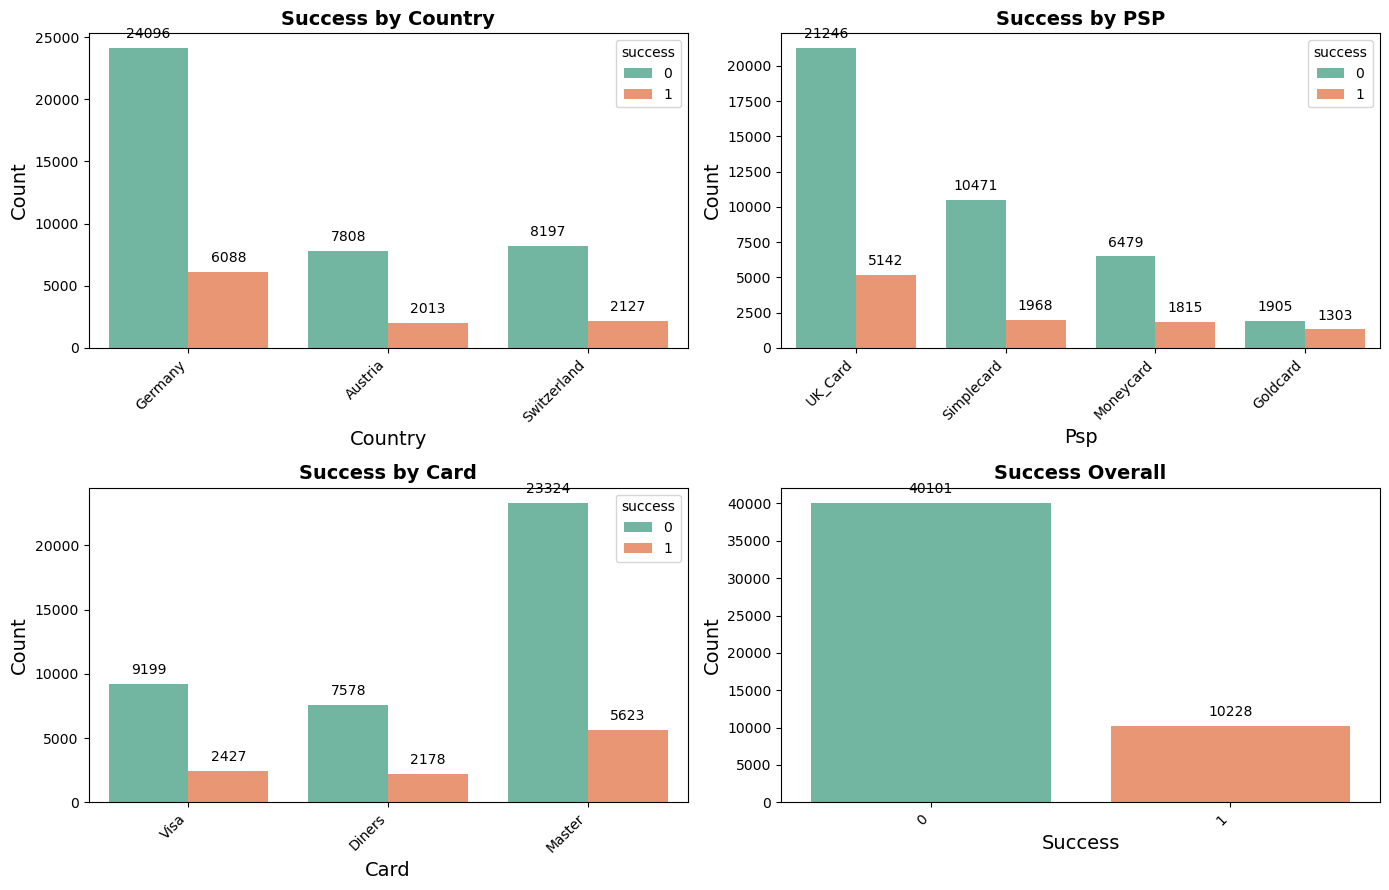

In [42]:
# Set the figure size
plt.figure(figsize=(14, 9))

# Define subplot grid
grid = (2, 2)

# Define plot titles
plot_titles = ["Success by Country", "Success by PSP", "Success by Card", "Success Overall"]

# Define subplot data and hue
subplots_data = [("country", "Country"), ("PSP", "PSP"), ("card", "Card"), ("success", "Success")]

# Loop through each subplot
for i, (data_col, title) in enumerate(subplots_data, start=1):
    plt.subplot(*grid, i)
    if data_col == "success":
        sns.countplot(data=df2, x=data_col, palette='Set2')
    else:
        sns.countplot(data=df2, x=data_col, hue="success", palette='Set2')
    plt.title(plot_titles[i-1], fontweight='bold', fontsize=14)  
    plt.xlabel(title.capitalize(), fontsize=14)  # Capitalize axis labels with increased font size
    plt.ylabel("Count", fontsize=14)  # Increased font size for y-axis label
    plt.xticks(rotation=45, ha='right')  
    for p in plt.gca().patches:
        plt.gca().annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Success by Country:
* This subplot shows the distribution of success (represented by hue) across different countries. It helps visualize whether success rates vary significantly between different countries.

Success by PSP (Payment Service Provider):
* This subplot displays the distribution of success (represented by hue) across different payment service providers. It helps analyze whether certain PSPs have higher success rates compared to others.

Success by Card:
* This subplot illustrates the distribution of success (represented by hue) across different card types. It provides insights into whether success rates differ based on the type of card used.

Success Overall:
* This subplot shows the overall distribution of success across the dataset. It provides a general overview of the success distribution without considering any specific categorical variable.

In [45]:
df2.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,Weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,1,1,1,0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,2,1,1,0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,1,1,1,0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,2,1,1,0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,1,1,1,0,Tuesday


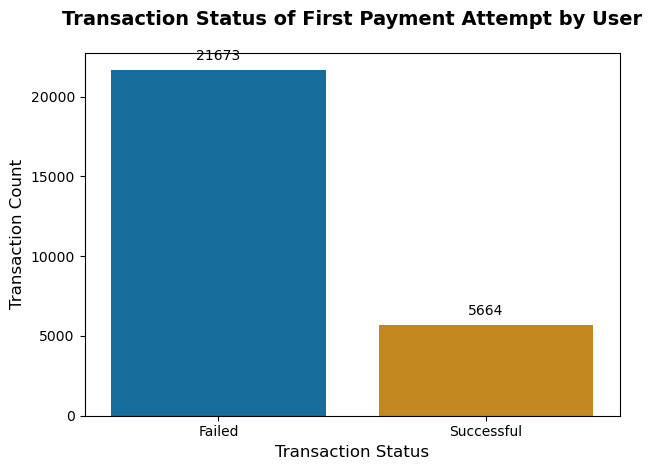

In [57]:
# Create a DataFrame for the first payment attempt
first_attempt_df = df2[df2["noOfAttempts"] == 1].groupby("success").size().reset_index(name="TransactionCount")

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create a count plot with a different color palette
sns.barplot(x='success', y='TransactionCount', data=first_attempt_df, ax=ax, palette='colorblind')

# Set the title of the current axes with increased padding
ax.set_title('Transaction Status of First Payment Attempt by User', fontsize=14, fontweight='bold', pad=20)

# Set the x and y-axis labels
ax.set_xlabel('Transaction Status', fontsize=12)
ax.set_ylabel('Transaction Count', fontsize=12)

# Update x-axis tick labels using dictionary
labels = {0: 'Failed', 1: 'Successful'}
ax.set_xticklabels([labels[0], labels[1]])

# Annotate each bar with its height value
for p in ax.patches:
    height = p.get_height()
    ax.annotate(format(height, '.0f'), (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=10, rotation=90 if height < 10 else 0)

# Adjust layout
plt.tight_layout()

# Display the figure
plt.show()


,card,PSP,Transaction Type,Total Fee
11,Visa,UK_Card,success_txnFee,18432.0
19,Master,UK_Card,failure_txnFee,15179.0
2,Diners,Simplecard,success_txnFee,2356.0
23,Visa,UK_Card,failure_txnFee,6144.0
12,Diners,Goldcard,failure_txnFee,3350.0


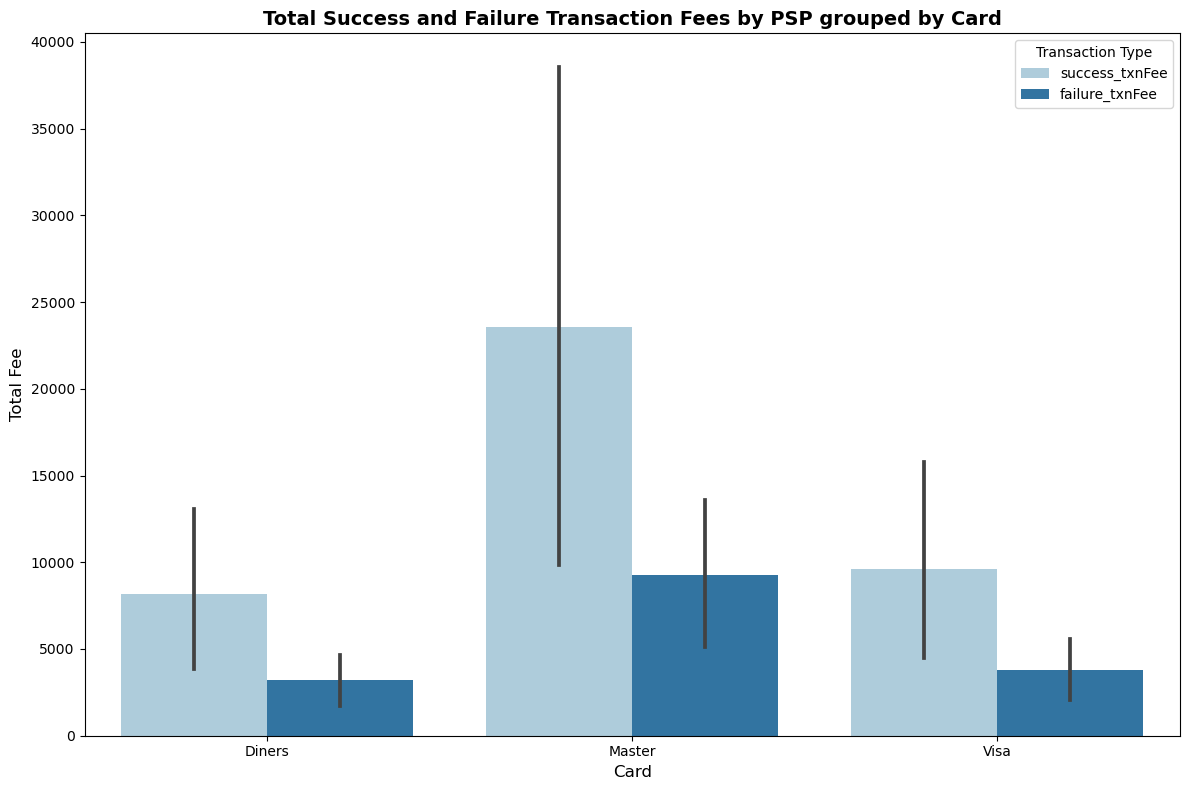

In [61]:
# Group by 'card' and 'PSP', and calculate the sum of 'success_txnFee' and 'failure_txnFee'
card_PSP = df2.groupby(["card", "PSP"])[["success_txnFee", "failure_txnFee"]].sum().reset_index()

# Melt the DataFrame to have 'Transaction Type' and 'Total Fee' columns
fee_summary = card_PSP.melt(id_vars=['card', 'PSP'], value_vars=['success_txnFee', 'failure_txnFee'],
                            var_name='Transaction Type', value_name='Total Fee')

# Display a sample of the DataFrame
display(fee_summary.sample(5))

# Create a figure and a set of subplots
fig, axs = plt.subplots(figsize=(12, 8))

# Create a grouped bar plot for total success and failure transaction fees by PSP grouped by Card
sns.barplot(x='card', y='Total Fee', hue='Transaction Type', data=fee_summary, ax=axs, palette='Paired')

# Set the title of the current axes
axs.set_title('Total Success and Failure Transaction Fees by PSP grouped by Card', fontsize=14, fontweight='bold')

# Set the x and y-axis labels
axs.set_xlabel('Card', fontsize=12)
axs.set_ylabel('Total Fee', fontsize=12)

# Show legend
axs.legend(title='Transaction Type')

# Adjust layout
plt.tight_layout()

# Display the figure
plt.show()


The dataframe df2 is group by 'card' and 'PSP' which calculate the sum of 'success_txnFee' and 'failure_txnFee'.

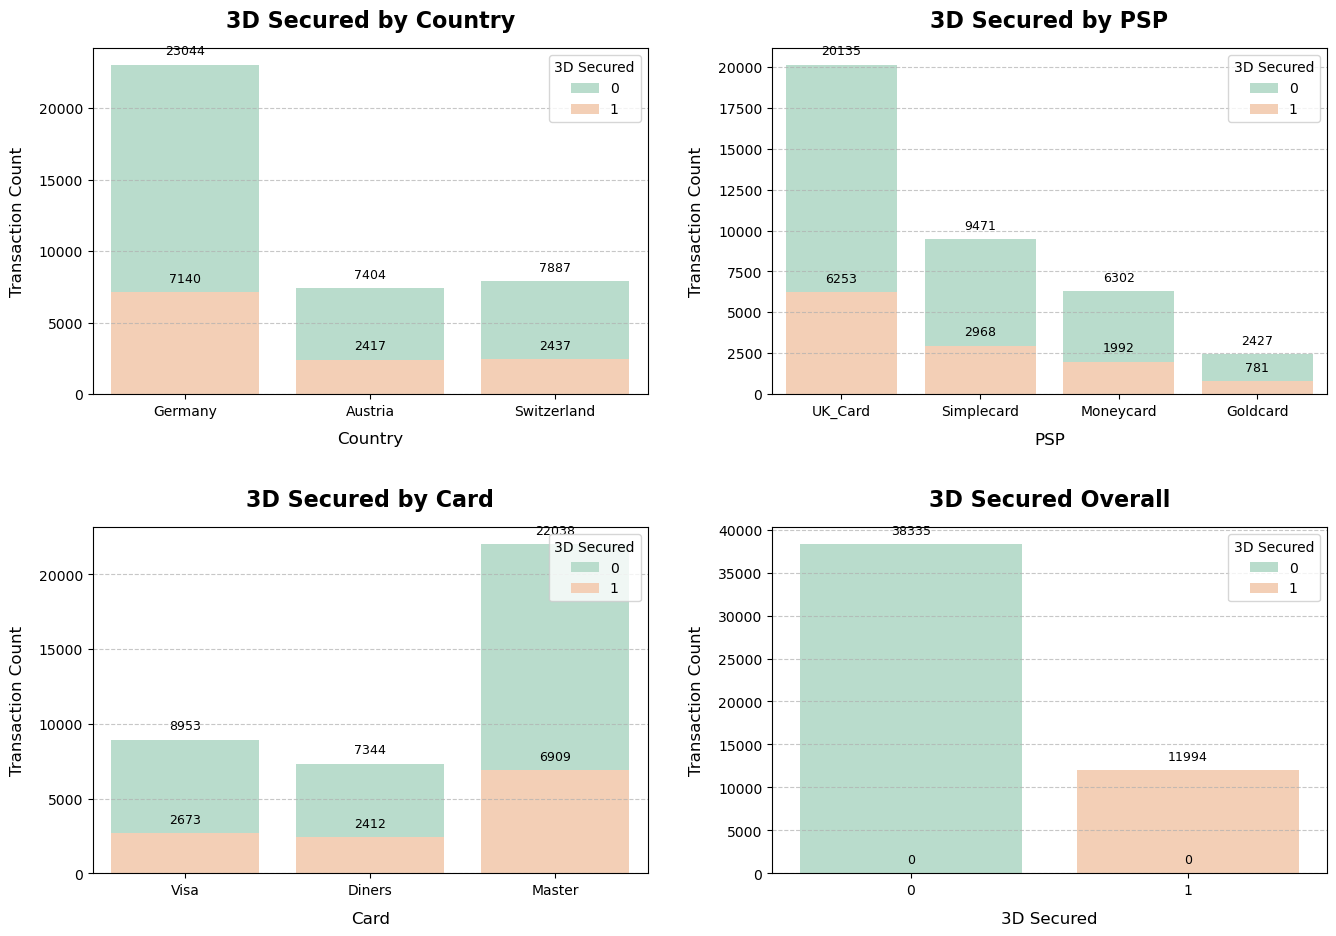

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(14, 10))

# Define subplot grid
grid = (2, 2)

# Define plot titles
plot_titles = ["3D Secured by Country", "3D Secured by PSP", "3D Secured by Card", "3D Secured Overall"]

# Define subplot data and hue
subplots_data = [("country", "Country"), ("PSP", "PSP"), ("card", "Card"), ("3D_secured", "3D Secured")]

# Loop through each subplot
for i, (data_col, title) in enumerate(subplots_data, start=1):
    plt.subplot(*grid, i)
    ax = sns.countplot(data=df2, x=data_col, hue="3D_secured", palette='Pastel2', dodge=False) 
    plt.title(plot_titles[i-1], fontsize=16, fontweight='bold', pad=15)  
    plt.xlabel(title, fontsize=12, labelpad=10)  
    plt.ylabel('Transaction Count', fontsize=12, labelpad=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(fontsize=10) 
    plt.yticks(fontsize=10)  
    plt.legend(title='3D Secured', loc='upper right')  

    # Annotate each bar with its height value
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=9)  # Adjust annotation position and font size

# Adjust layout and add space between subplots
plt.tight_layout(pad=3)

# Show the plot
plt.show()


3D Secured by Country:
* This subplot shows the distribution of transactions marked as 3D secured (represented by hue) across different countries. It helps visualize whether 3D secure transactions are more prevalent in certain countries.

3D Secured by PSP (Payment Service Provider):
* This subplot displays the distribution of 3D secured transactions (represented by hue) across different payment service providers. It helps analyze whether certain PSPs have a higher proportion of 3D secured transactions compared to others.

3D Secured by Card:
* This subplot illustrates the distribution of 3D secured transactions (represented by hue) across different card types. It provides insights into whether 3D secure transactions are more common with specific card types.

3D Secured Overall:
* This subplot shows the overall distribution of 3D secured transactions across the dataset. It provides a general overview of the prevalence of 3D secured transactions without considering any specific categorical variable.

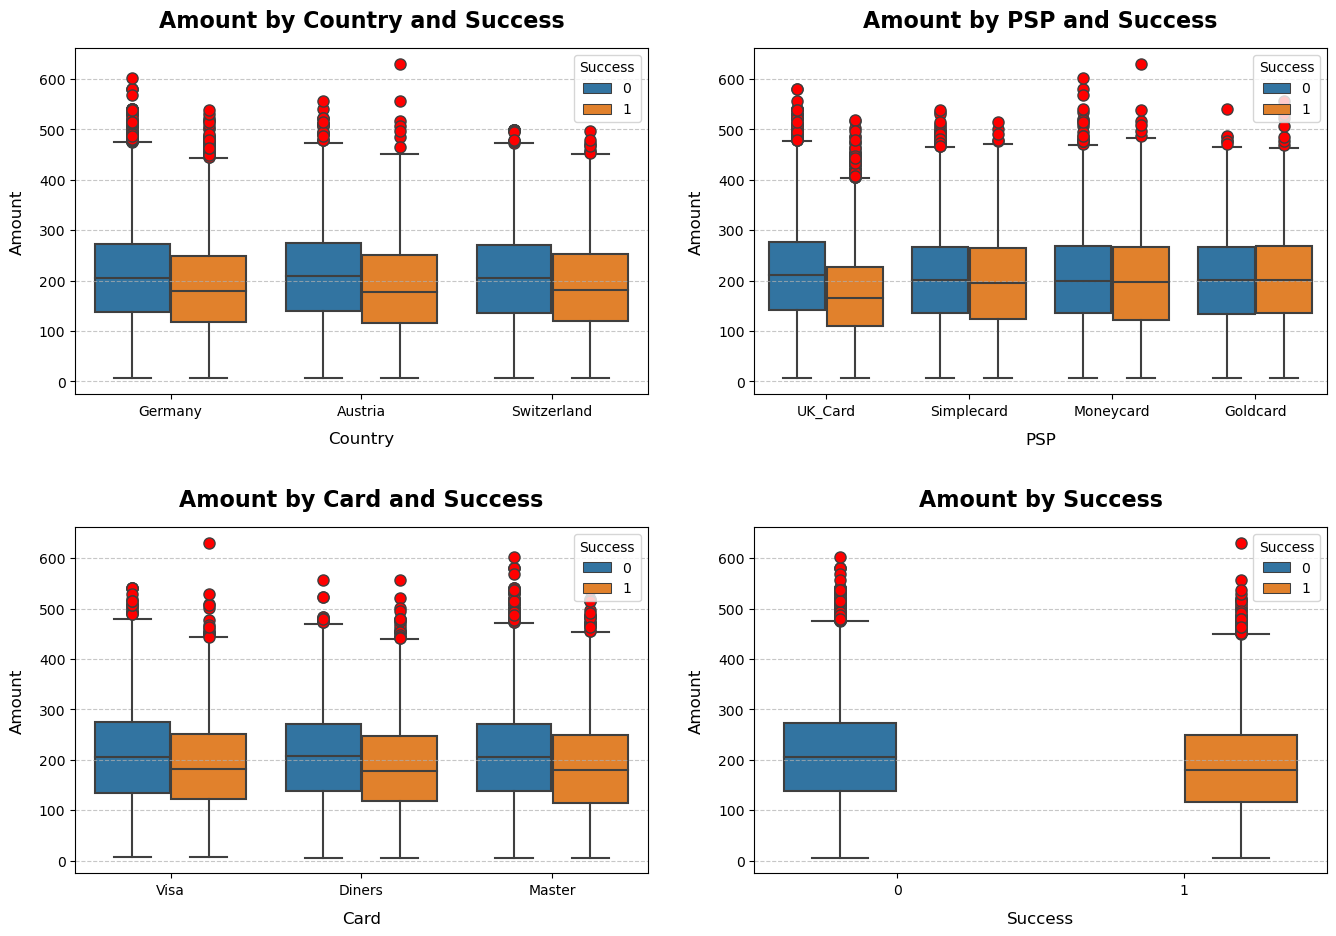

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(14, 10))

# Define subplot grid
grid = (2, 2)

# Define plot titles
plot_titles = ["Amount by Country and Success", "Amount by PSP and Success", "Amount by Card and Success", "Amount by Success"]

# Define subplot data
subplots_data = [("country", "Country"), ("PSP", "PSP"), ("card", "Card"), ("success", "Success")]

# Define color palette
colors = ['#1f77b4', '#ff7f0e']

# Loop through each subplot
for i, (data_col, title) in enumerate(subplots_data, start=1):
    plt.subplot(*grid, i)
    ax = sns.boxplot(data=df2, x=data_col, y="amount", hue="success", palette=colors, flierprops=dict(marker='o', markerfacecolor='r', markersize=8, linestyle='none'))  # Set color palette and style for outliers
    plt.title(plot_titles[i-1], fontsize=16, fontweight='bold', pad=15)  
    plt.xlabel(title, fontsize=12, labelpad=10)  
    plt.ylabel('Amount', fontsize=12, labelpad=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(fontsize=10) 
    plt.yticks(fontsize=10)  
    plt.legend(title='Success', loc='upper right')  

# Adjust layout and add space between subplots
plt.tight_layout(pad=3)

# Show the plot
plt.show()


Amount by Country and Success:
* This subplot displays box plots of transaction amounts grouped by country and success status.It helps visualize the distribution of transaction amounts across different countries, distinguishing between successful and unsuccessful transactions.The box plots allow for easy comparison of the central tendency, spread, and skewness of transaction amounts within each category.

Amount by PSP and Success:
* This subplot illustrates box plots of transaction amounts grouped by payment service provider (PSP) and success status. It aids in understanding how transaction amounts vary across different PSPs, considering both successful and unsuccessful transactions.

Amount by Card and Success:
* This subplot presents box plots of transaction amounts grouped by card type and success status. It provides insights into the distribution of transaction amounts across different card types, differentiated by success status.

Amount by Success:
* This subplot shows box plots of transaction amounts grouped solely by success status. It gives a general overview of how transaction amounts differ between successful and unsuccessful transactions.

In [85]:
# Extract numeric columns for correlation analysis
numeric_columns = df2.select_dtypes(include=['int64', 'float64']).columns
numeric_df = df2[numeric_columns]

In [86]:
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

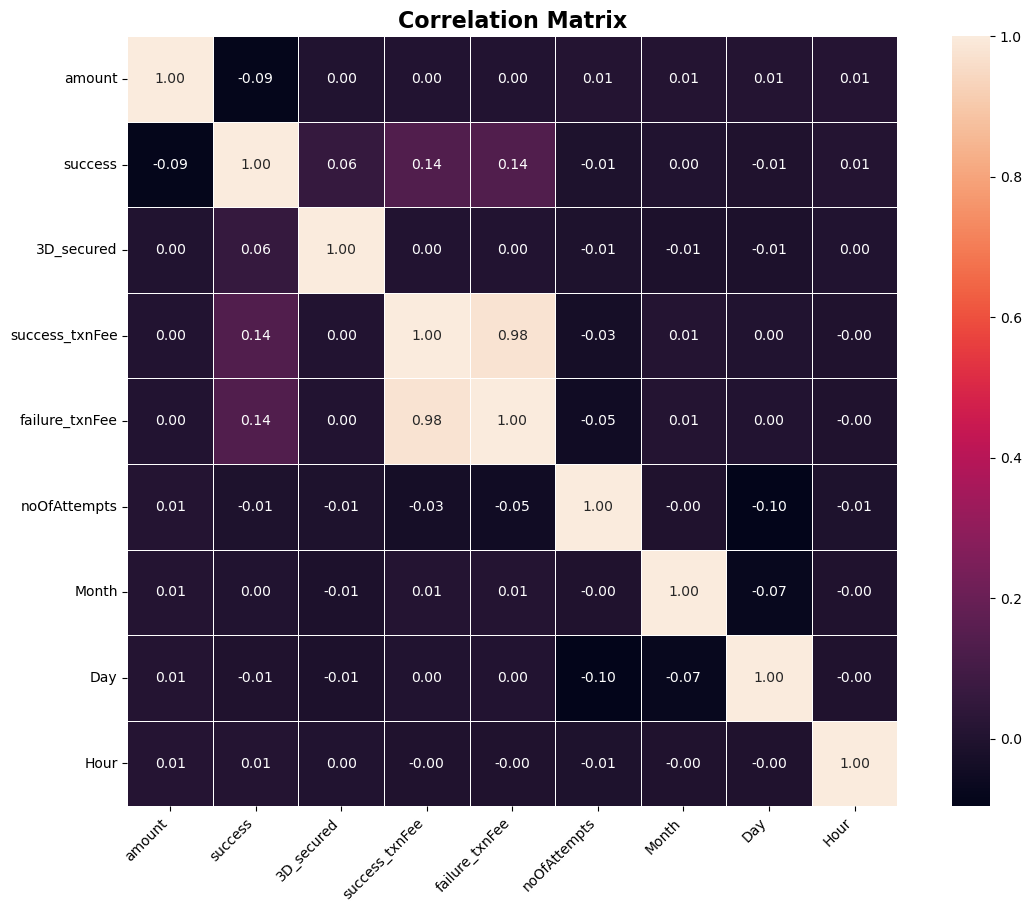

In [101]:
# Set the figure size
plt.figure(figsize=(14, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="rocket", fmt=".2f", linewidths=0.5, square=True)

# Set title and adjust font size
plt.title("Correlation Matrix", fontsize=16, fontweight='bold')

# Rotate x-axis & y-axis tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10)

# Show the plot
plt.show()


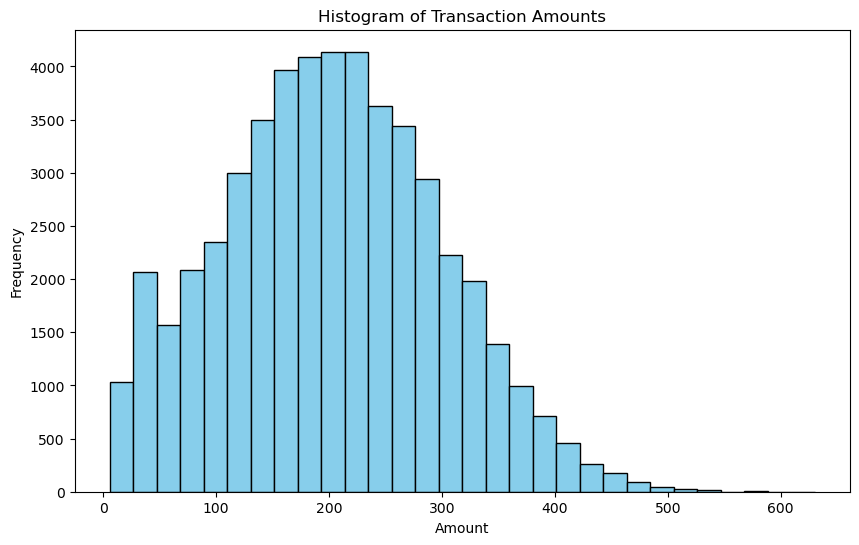

In [110]:
plt.figure(figsize=(10, 6))
plt.hist(df2['amount'], bins=30, edgecolor='black', color='skyblue')

# Set title and labels
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# Show the plot
plt.show()

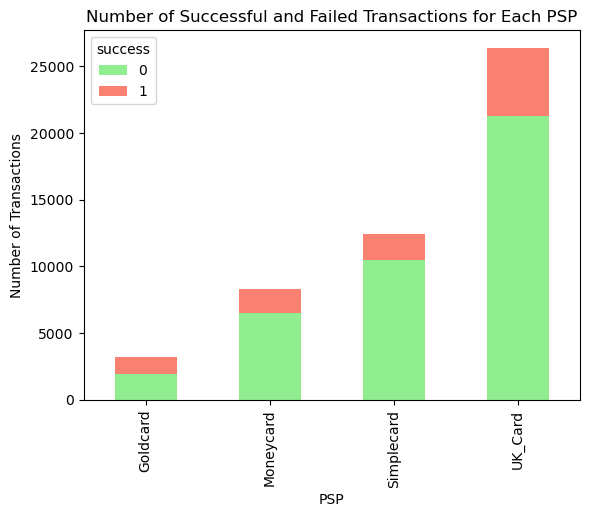

In [116]:
# Bar chart of successful and failed transactions for each PSP
df2.groupby('PSP')['success'].value_counts().unstack().plot(kind='bar', stacked=True, color=['lightgreen', 'salmon'])
plt.title('Number of Successful and Failed Transactions for Each PSP')
plt.xlabel('PSP')
plt.ylabel('Number of Transactions')
plt.show()

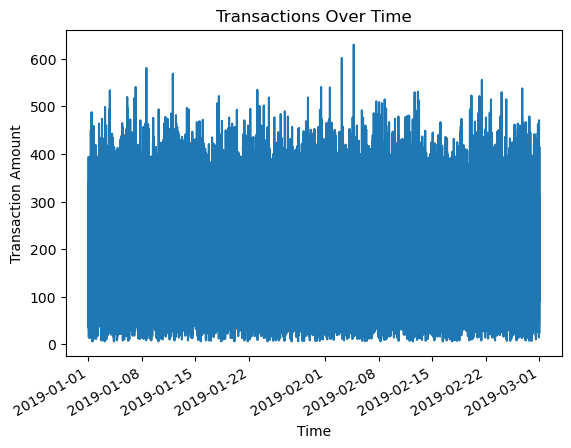

In [117]:
# Time series plot of transactions over time
df2.set_index('tmsp')['amount'].plot()
plt.title('Transactions Over Time')
plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.show()

PSP
Goldcard      0.406172
Moneycard     0.218833
Simplecard    0.158212
UK_Card       0.194861
Name: success, dtype: float64


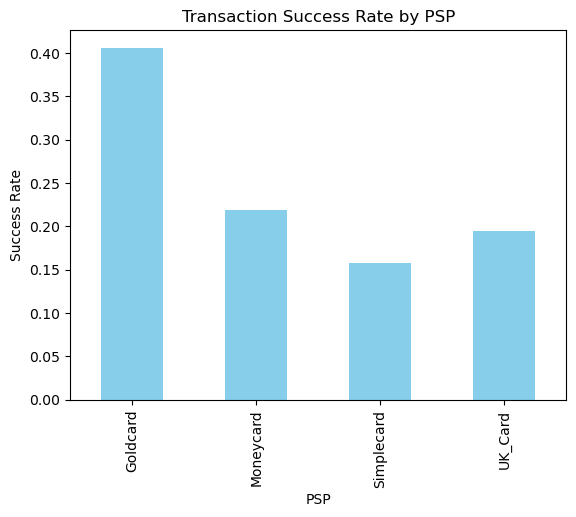

In [127]:
success_rate_by_psp = df2.groupby('PSP')['success'].mean()
print(success_rate_by_psp)
success_rate_by_psp.plot(kind='bar', color = 'skyblue')
plt.title('Transaction Success Rate by PSP')
plt.xlabel('PSP')
plt.ylabel('Success Rate')
plt.show()

card
Diners    0.223247
Master    0.194252
Visa      0.208756
Name: success, dtype: float64


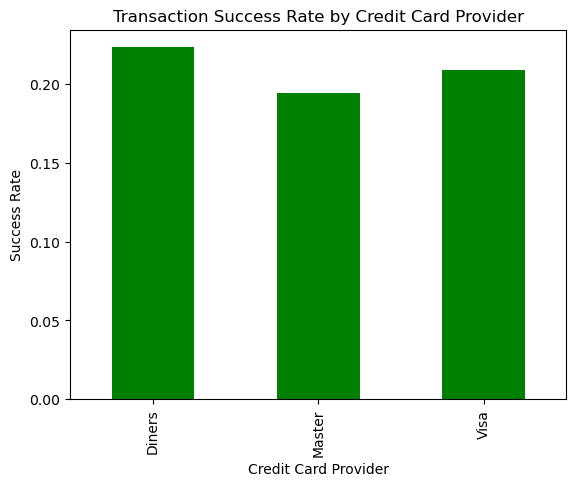

In [133]:
success_rate_by_card = df2.groupby('card')['success'].mean()
print(success_rate_by_card)
success_rate_by_card.plot(kind='bar' , color = 'green')
plt.title('Transaction Success Rate by Credit Card Provider')
plt.xlabel('Credit Card Provider')
plt.ylabel('Success Rate')
plt.show()

3D_secured
0    0.189879
1    0.245873
Name: success, dtype: float64


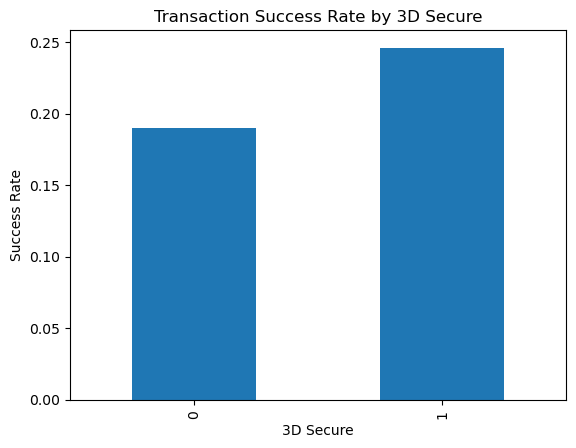

In [134]:
success_rate_by_3d_secure = df2.groupby('3D_secured')['success'].mean()
print(success_rate_by_3d_secure)
success_rate_by_3d_secure.plot(kind='bar')
plt.title('Transaction Success Rate by 3D Secure')
plt.xlabel('3D Secure')
plt.ylabel('Success Rate')
plt.show()

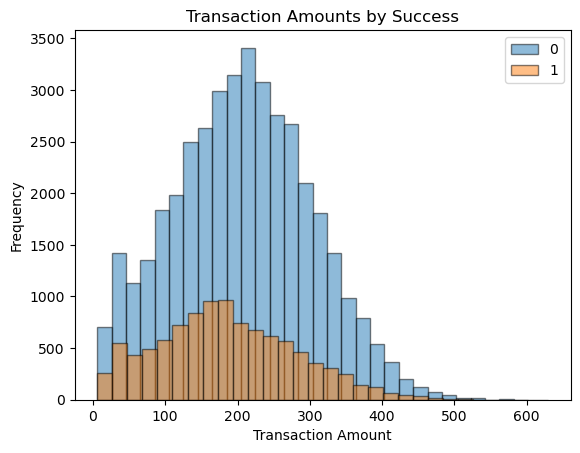

In [139]:
df2.groupby('success')['amount'].plot(kind='hist', legend=True, alpha=0.5, bins=30, edgecolor='black')
plt.title('Transaction Amounts by Success')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [141]:
# Display the number of attempts
attempts_count = df2['noOfAttempts'].value_counts()
print(attempts_count)

1     27337
2     12303
3      5690
4      2642
5      1240
6       606
7       287
8       144
9        79
10        1
Name: noOfAttempts, dtype: int64


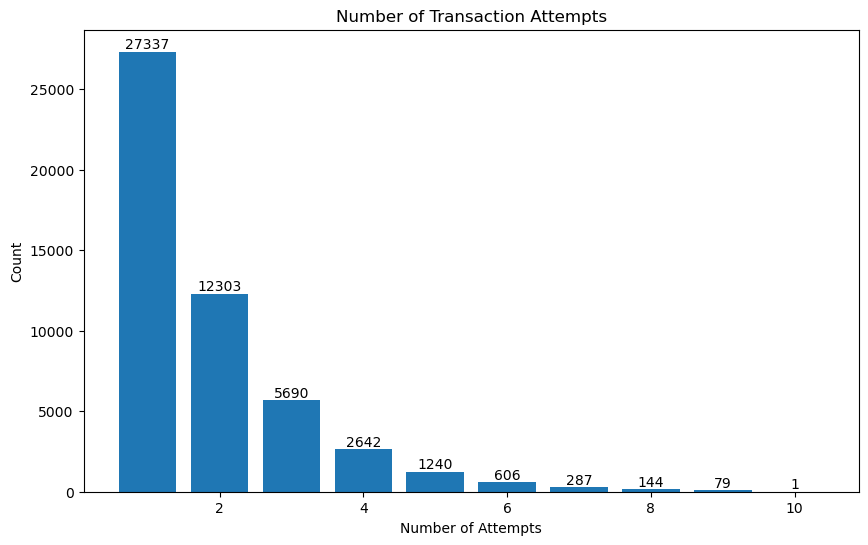

In [143]:
# Get the number of attempts
attempts_count = df2['noOfAttempts'].value_counts()

# Create a new figure
plt.figure(figsize=(10,6))

# Define color for the bars
bar_color = '#1f77b4'  # Blue

# Create a bar plot
bars = plt.bar(attempts_count.index, attempts_count.values, color=bar_color)

# Set the title and labels
plt.title('Number of Transaction Attempts')
plt.xlabel('Number of Attempts')
plt.ylabel('Count')

# Annotate each bar with its height value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Show the plot
plt.show()


## 4. Model Building and Evaluation

In [145]:
X = df4.drop(["tmsp","success"],axis=1)
y = df4['success']

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.1 Baseine Model

Training set:
Accuracy: 0.7988724138787472
Precision: 0.7546017498900598
Recall: 0.7988724138787472
F1 Score: 0.7175445619170696
Confusion Matrix:
[[31963   151]
 [ 7947   202]]


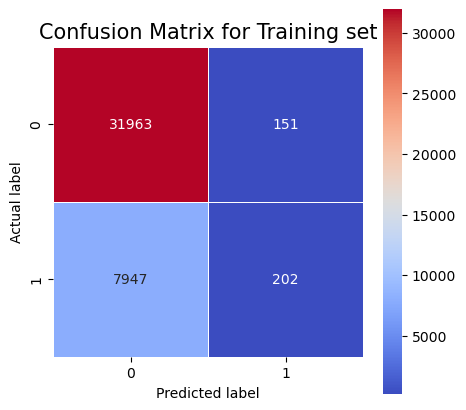

Testing set:
Accuracy: 0.7911782237234254
Precision: 0.7059777579692178
Recall: 0.7911782237234254
F1 Score: 0.7065566749652985
Confusion Matrix:
[[7933   54]
 [2048   31]]


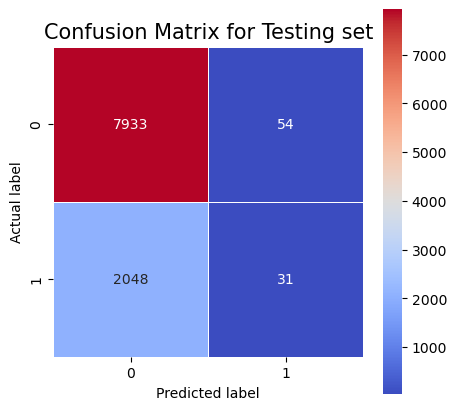

In [147]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model initialization
model = LogisticRegression(solver='liblinear')

# Define hyperparameters for grid search
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Function to evaluate the model
def evaluate_model(model, X, y, dataset):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)

    print(f"{dataset} set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

    # Plotting the confusion matrix with different colors
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='coolwarm')  # Change cmap to 'coolwarm'
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix for {dataset} set', size=15)
    plt.show()

# Evaluate the best model on the training set
evaluate_model(best_model, X_train_scaled, y_train, "Training")

# Evaluate the best model on the testing set
evaluate_model(best_model, X_test_scaled, y_test, "Testing")


* This code is used for building, tuning, and evaluating a logistic regression classifier for binary classification tasks.
* By utilizing hyperparameter tuning with grid search, it helps in finding the optimal hyperparameters for the logistic regression model, thereby improving its performance.
* The evaluation metrics (accuracy, precision, recall, F1 score) and the confusion matrix provide a comprehensive understanding of the model's performance on both training and testing datasets.
* The visualization of the confusion matrix aids in identifying areas where the model may be misclassifying instances, which can inform further refinement of the model or the dataset.
* Overall, this code serves as a valuable tool for assessing and refining logistic regression models for binary classification tasks.

### 4.2 Accurate Model

Training set:
Accuracy: 0.8337183021632765
Precision: 0.8386841642019384
Recall: 0.8337183021632765
F1 Score: 0.790537244525392
Confusion Matrix:
[[31844   270]
 [ 6425  1724]]


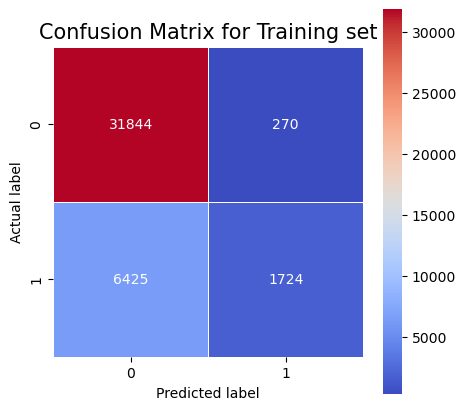

Testing set:
Accuracy: 0.7902841247764752
Precision: 0.7313990513757354
Recall: 0.7902841247764752
F1 Score: 0.7271098511898567
Confusion Matrix:
[[7787  200]
 [1911  168]]


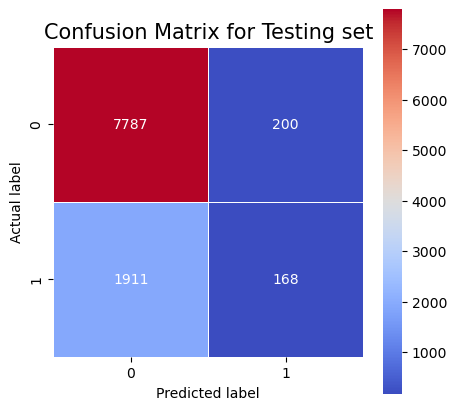

In [150]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the XGBoost classifier
clf = xgb.XGBClassifier()
clf.fit(X_train_scaled, y_train)

# Function to evaluate the model
def evaluate_model(model, X, y, dataset):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)

    print(f"{dataset} set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

    # Plotting the confusion matrix with a different color scheme
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='coolwarm')  # Change cmap to 'coolwarm'
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix for {dataset} set', size=15)
    plt.show()

# Evaluate the model on the training set
evaluate_model(clf, X_train_scaled, y_train, "Training")

# Evaluate the model on the testing set
evaluate_model(clf, X_test_scaled, y_test, "Testing")


* XGBoost is a powerful machine learning algorithm known for its efficiency and effectiveness in various classification tasks.
* This code trains an XGBoost classifier on the training data and evaluates its performance on both training and testing datasets.
* By evaluating metrics such as accuracy, precision, recall, and F1 score, the code provides a comprehensive understanding of the model's performance.
* The confusion matrix visualization further aids in understanding how well the model is performing in terms of correctly classifying instances and identifying areas where it may be misclassifying instances.
* Overall, this code serves as a valuable tool for training and evaluating XGBoost classifiers for classification tasks, providing insights into model performance and potential areas for improvement.

In [151]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to compute evaluation metrics
def compute_metrics(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Compute evaluation metrics for both models on the training set
metrics_train1 = compute_metrics(best_model, X_train_scaled, y_train)
metrics_train2 = compute_metrics(clf, X_train_scaled, y_train)

# Compute evaluation metrics for both models on the testing set
metrics_test1 = compute_metrics(best_model, X_test_scaled, y_test)
metrics_test2 = compute_metrics(clf, X_test_scaled, y_test)

# Create a DataFrame to display the evaluation metrics
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Logistic Regression (Train)': metrics_train1,
    'XGBoost (Train)': metrics_train2,
    'Logistic Regression (Test)': metrics_test1,
    'XGBoost (Test)': metrics_test2
})

print(metrics)


      Metric  Logistic Regression (Train)  XGBoost (Train)  \
0   Accuracy                     0.798872         0.833718   
1  Precision                     0.754602         0.838684   
2     Recall                     0.798872         0.833718   
3   F1 Score                     0.717545         0.790537   

   Logistic Regression (Test)  XGBoost (Test)  
0                    0.791178        0.790284  
1                    0.705978        0.731399  
2                    0.791178        0.790284  
3                    0.706557        0.727110  


## 5. Model Deployment

#### Proposal for Model Deployment:

In order to seamlessly integrate the predictive model into the company's operational workflow, we suggest a phased approach focusing on usability, practicality, and smooth integration with existing systems. Our proposed deployment options include embedding the model within current systems, developing a standalone application, or implementing a graphical user interface (GUI). Each option offers distinct advantages and considerations, as detailed below:

#### 1. Integration into Existing Systems:

Description: This approach involves integrating the predictive model directly into the company's current transaction processing system.

Advantages:

- Seamless Integration: Integrating the model within existing systems ensures a smooth transition with minimal disruption to ongoing workflows.
- Real-time Decision-Making: By embedding the model within the transaction processing system, decisions on credit card routing can be made in real-time, enhancing efficiency and responsiveness.
- Reduced Manual Intervention: Automation of the credit card routing process reduces the need for manual intervention, leading to streamlined operations and decreased error risk.

Considerations:

- Technical Integration: Integration with current systems may necessitate coordination with IT departments and adherence to specific technical requirements.
- System Compatibility: Ensuring compatibility with existing systems and infrastructure is crucial to avoid conflicts or performance issues.

#### 2. Development of a Standalone Application:

Description: This approach involves creating a standalone application to host the predictive model, offering a dedicated platform for credit card routing decisions.

Advantages:

- Flexibility and Customization: A standalone application allows for customization and user interface design tailored to specific user needs and workflows.
- Centralized Management: Centralizing the predictive model within a standalone application facilitates easier management and maintenance, with updates and enhancements implemented as necessary.
- Enhanced Security: Hosting the model within a dedicated application may enhance security measures, safeguarding sensitive transaction data and ensuring compliance with regulatory requirements.

Considerations:

- User Training: Users may require training to effectively utilize the standalone application and grasp its functionalities.
- Development and Maintenance: Developing and maintaining a standalone application entails additional resources and ongoing support from development teams.

#### 3. Implementation of a Graphical User Interface (GUI):

Description: This approach involves developing a graphical user interface (GUI) to provide an intuitive platform for interacting with the predictive model.

Advantages:

- User-Friendly Interface: A GUI offers an intuitive interface, simplifying interaction with the predictive model and enabling users to input data, view results, and make decisions effortlessly.
- Accessibility: A GUI can be accessed from any internet-connected device, providing flexibility and accessibility for users across various departments or locations.
- Visualizations and Insights: Incorporating visualizations and insights generated by the predictive model into the GUI enhances user comprehension and aids decision-making.

Considerations:

- Design and Usability: Designing an effective GUI requires careful consideration of user experience (UX) principles and usability testing to ensure intuitive navigation and functionality.
- Integration with Backend Systems: The GUI must be seamlessly integrated with backend systems to retrieve data and communicate with the predictive model effectively.

## Conclusion

Accuracy:

- XGBoost performs better on the training dataset than logistic regression, with an accuracy of 83.37% as opposed to 79.88%.On the test dataset, however, XGBoost performs little less well than logistic regression, with an accuracy of 79% as opposed to 79.11%.

Precision: 

- When compared to logistic regression, XGBoost exhibits better precision on training and testing datasets. This suggests that XGBoost can minimize false positives while accurately identifying positive cases, or real positives.

Recall:

- Both XGBoost and logistic regression have comparable recall scores for training and testing datasets, demonstrating their capacity to distinguish genuine positives from all real positive occurrences.

F1 Score:

- In comparison to logistic regression, XGBoost produces a higher F1 score on both training and testing datasets, indicating a better trade-off between precision and recall.

All things considered, XGBoost outperforms logistic regression in terms of accuracy, precision, and F1 score—especially when it comes to the training dataset. Even yet, logistic regression continues to perform competitively, especially when applied to the testing dataset. In order to optimize both models in light of the performance discrepancies, more investigation could be required.
